In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


### We download the Dogs and Cats dataset(it va mushuklar datasetini kompyuterimiz xotirasiga yuklaymiz)

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0  206k    0     0   459k      0  0:29:13 --:--:--  0:29:13  459k
  0  786M    0 4683k    0     0  3207k      0  0:04:11  0:00:01  0:04:10 3210k
  1  786M    1 10.9M    0     0  4586k      0  0:02:55  0:00:02  0:02:53 4587k
  2  786M    2 16.6M    0     0  4955k      0  0:02:42  0:00:03  0:02:39 4956k
  2  786M    2 22.3M    0     0  5085k      0  0:02:38  0:00:04  0:02:34 5085k
  3  786M    3 27.9M    0     0  5236k      0  0:02:33  0:00:05  0:02:28 5665k
  4  786M    4 33.2M    0     0  5248k      0  0:02:33  0:00:06  0:02:27 5843k
  4  786M    4 38.3M    0     0  5269k      0  0:02:32  0:00:07  0:02:25 5604k
  5  786M    5 44.7M    0     0  5401k      0  0:02:29  0:00:08  0:02:21 5707k
  6  786M    6 50.3M    0     0  5449k      0  0:02

In [1]:
!dir

 Volume in drive D is 1TB HDD
 Volume Serial Number is C838-CEB9

 Directory of d:\Projects\AI\Hand-on Machine learning projects\Dog and Cat Classification

04/05/2022  02:48 AM    <DIR>          .
04/05/2022  02:48 AM    <DIR>          ..
04/05/2022  02:54 AM            15,129 catdogclassification.ipynb
02/10/2017  09:55 AM            35,545 MSR-LA - 3467.docx
02/10/2017  09:51 AM               104 readme[1].txt
               3 File(s)         50,778 bytes
               2 Dir(s)  931,558,252,544 bytes free


## Filter out corrupted images (Yaxshi kodlanmagan rasmlarni datasetimizdan olib tashlaymiz)

In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("D:\Projects\AI\Hand-on Machine learning projects\PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1578 images


#### Generate Dataset ( Datasetni train qilish uchun tayyorlaymiz)

In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Projects\AI\Hand-on Machine learning projects\PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Projects\AI\Hand-on Machine learning projects\PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.


C:\Users\ADMIN\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


### Let's visualize the data (Ma'lumotlarni ko'raylik...)
Here are the first 9 images in the training dataset. As you can see, label 1 is 'dog' and label 0 is 'cat'.
(Bu yerda train qiladigan datasetimizdagi 9 ta rasm. label1 'it' va label 0 'mushuk' uchun.)

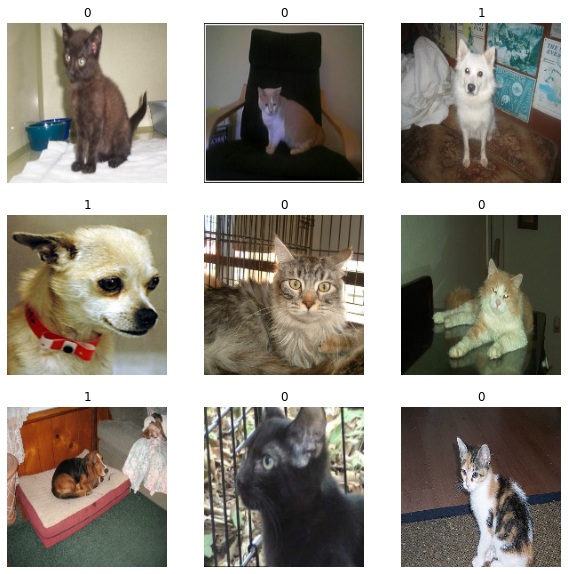

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Image data augmentation

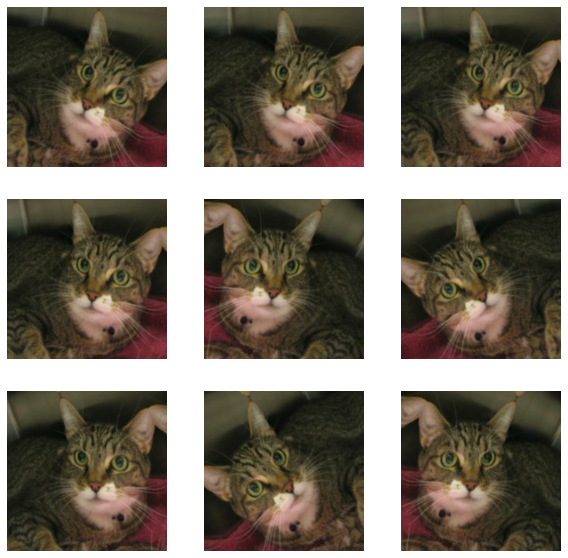

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Configure the dataset for performance (dataset dan foydalanish uchun sozlaymiz)

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [8]:
import pydot

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [11]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


KeyboardInterrupt: 